In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy.optimize import curve_fit
from tqdm import tqdm
import matplotlib.gridspec as gridspec
import seaborn
import matplotlib as mpl
import pandas as pd
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as mpatches
from scipy.optimize import curve_fit
from matplotlib import gridspec
import itertools
import multiprocessing as mp
from wquantiles import quantile
import pickle

In [7]:
def exp_fit(x, lamb, k, ped):
    return k*lamb*pow(np.e, -x*lamb) + ped

In [8]:
def double_exp_fit(x, lamb1, lamb2, k, ped):
    return 3.52*k*lamb1*pow(np.e, -x*lamb1) + k*lamb2*pow(np.e, -x*lamb2) + ped

In [9]:
def checker(x, lamb1, lamb2, a, b):
    return a*lamb1*pow(np.e, -x*lamb1) + b*pow(np.e, -x*lamb2)

In [10]:
# Random seed
np.random.seed(42)

# Matplotlib settings
plt.rcParams['font.serif'] = 'Ubuntu'

In [11]:
def read_data(file):
    data = []
    with open(file) as reader:
        for line in reader:
            data.append(map(float,line.rstrip().split('\t')))
    data = np.array(data)

    if 'Lifetime' in file:
        columns = ['clock', 'life']
    else:
        columns = ['clock', 'e', 'mu', 'life']

    data = pd.DataFrame(data, columns=columns)
    return data

In [12]:
def lifetime_fit(data, save_name, plot_top, system_err=False):
    
    if system_err:
        min_cuts = np.linspace(1.0, 2.0, 10)
        max_cuts = np.linspace(13., 17.5, 10)
        bin_mults = np.linspace(30, 60, 4).astype(int)

        def get_life(row):
            min_cut,max_cut,bin_mult = row
            fig1 = plt.figure()
            n, bins, patches = plt.hist(data, bins=np.arange(0+.001,20+.001,0.002*int(bin_mult)), color='b')
            middles = (bins[1:] + bins[:-1]) / 2.
            kept_ixes = [ix for ix in range(len(middles)) if min_cut<=middles[ix]<=max_cut]
            uncert = np.sqrt(n)[kept_ixes]
            popt,pcov = curve_fit(exp_fit ,middles[kept_ixes] , n[kept_ixes], sigma=uncert)    
            lifetime = 1./popt[0]   
            plt.close(fig1)

            return lifetime, pcov[0][0]

        lifetimes = np.array(map(get_life, tqdm(itertools.product(min_cuts, max_cuts, bin_mults))))
        
        pickle.dump( lifetimes, open( save_name[:-4] + '.p', "wb" ) )
    
    bin_mult = 50
    min_cut = 1
    max_cut = 15.0
    
    fig = plt.figure(figsize=(10,8))
    G = gridspec.GridSpec(3,1)
    ax1 = plt.subplot(G[:2, :])
    
    n, bins, patches = ax1.hist(data, bins=np.arange(0+.001,20+.001,0.002*bin_mult), color='b')
    middles = (bins[1:] + bins[:-1]) / 2.
    kept_ixes = [ix for ix in range(len(middles)) if min_cut<=middles[ix]<=max_cut]
    uncert = np.sqrt(n)[kept_ixes]
    
    p0=np.array([1./2.04, 2.26616742e+03, 3.14100198e+01])
    popt,pcov = curve_fit(exp_fit ,middles[kept_ixes] , n[kept_ixes], 
                          sigma=uncert,
                          p0=p0, # p0=[1/2.04, 1/2.19, 1000, 80]   
                            #bounds=(p0*.9, p0*1.1),
                         ) 
    preds = np.array([exp_fit(mi, popt[0], popt[1], popt[2]) for mi in middles])
    print 1./popt, np.sqrt(np.diag(pcov))
    
    chi2 = np.mean(np.square((preds[kept_ixes] - n[kept_ixes]) / np.sqrt(n[kept_ixes])))
    
    plt.plot(middles, preds, c='g')
    ax1.axvline(min_cut, linestyle='--', color='k')
    ax1.axvline(max_cut, linestyle='--', color='k')
    
    minorLocator = MultipleLocator(1.0)
    ax1.yaxis.set_minor_locator(minorLocator)
    ax1.xaxis.set_minor_locator(minorLocator)
    ax1.grid(which = 'minor')
    
    plt.xlabel(r'$\Delta t$ $(\mu s)$')
    
#     plt.annotate(r'Lifetime: ' + str(round(1./popt[0], 2)), xy=(0.75, 0.5), xycoords = 'axes fraction')
    
    plt.legend(handles=[mpatches.Patch(color='b', label='Events'),
                        mpatches.Patch(color='k', label='Cuts'),
                        mpatches.Patch(color='g', label='Fit')])
    
    plt.yscale('log')
    plt.ylabel('Counts')
    #plt.annotate(plot_top, xy=(0.0, 1.0), fontsize=20, xycoords = 'axes fraction')
    
    ax2 = plt.subplot(G[2,:], sharex=ax1)
    ax2.bar(middles[kept_ixes],(preds[kept_ixes] - n[kept_ixes]) / np.sqrt(n[kept_ixes]), middles[1]-middles[0], 0)
    
    ax2.add_patch(mpatches.Rectangle((ax2.get_xlim()[0], -1), ax2.get_xlim()[1] - ax2.get_xlim()[0], 2, alpha=.2, color='goldenrod'))
    plt.annotate(r'$\sqrt{\chi^2 /n}$ = ' + str(round(np.sqrt(chi2), 2)), xy=(0.85, 0.7), xycoords = 'axes fraction')
    
    minorLocator = MultipleLocator(1.0)
    ax2.yaxis.set_minor_locator(minorLocator)
    ax2.xaxis.set_minor_locator(minorLocator)
    ax2.grid(which = 'minor')
    
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
    
    
    plt.tight_layout()
    plt.savefig(save_name)
    plt.show()
    
    return popt, n, middles


In [8]:
df0 = read_data('../data/2017_09_14_Muon_Lifetime.txt')
df1 = read_data('../data/2017_09_21_Mass.txt')
df2 = read_data('../data/2017_09_21_Mass2.txt')

0it [00:00, ?it/s]/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in power
  
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  
400it [02:59,  3.29it/s]


[  2.13017665e+00   1.81365473e-04   1.36909872e-02] [  4.58694296e-03   3.49685358e+01   1.38848524e+00]


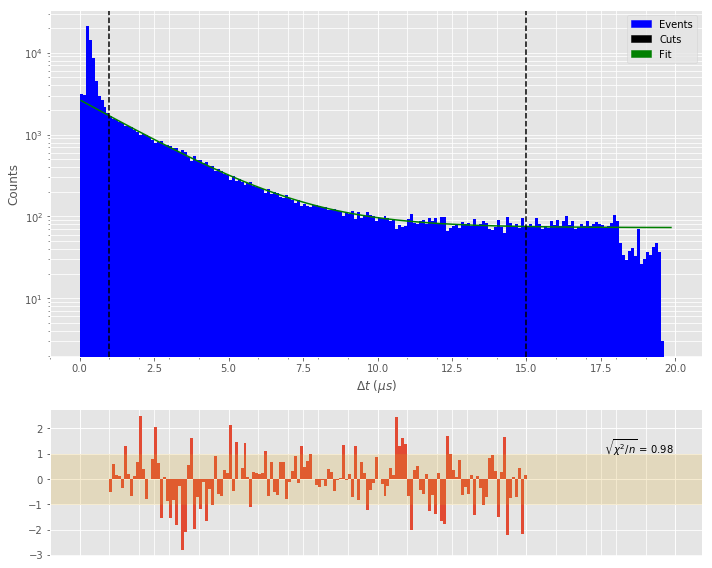

In [9]:
outs = lifetime_fit(np.append(np.append(df2.life.values, df1.life.values), df0.life.values), '../plots/final_massALL.pdf', 'Run ALL', system_err = True)

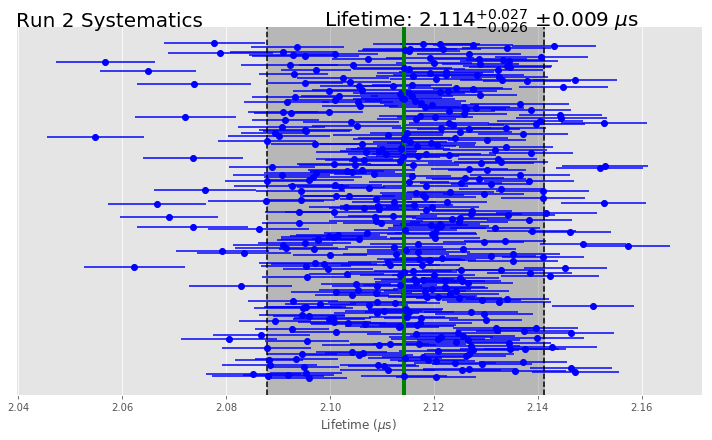

In [15]:
lifetimes = pickle.load( open( "../plots/final_mass2.p", "rb" ) )
plot_name = '../plots/final_mass2_syst.pdf'
title_name = r'Run 2 Systematics'

np.random.seed(24)
lifetimes = np.random.permutation(lifetimes)
lifetime = np.dot(lifetimes[:,0],1./np.sqrt(lifetimes[:,1])) / sum(1./np.sqrt(lifetimes[:,1]))
lerr = lifetime - quantile(lifetimes[:,0], 1./np.sqrt(lifetimes[:,1]), .05)
rerr = quantile(lifetimes[:,0], 1./np.sqrt(lifetimes[:,1]), .95) - lifetime

fig = plt.figure(figsize=(10,6))
plt.errorbar(lifetimes[:,0], range(len(lifetimes)), xerr=np.sqrt(lifetimes[:,1]), fmt='o', color='b')
# plt.axvline(np.mean(lifetimes[:,0]), color='r')
# plt.axvline(np.median(lifetimes[:,0]), color='k')
# plt.axvline(quantile(lifetimes[:,0], 1./np.sqrt(lifetimes[:,1]), .5), color='b')

# plt.axvline(np.percentile(lifetimes[:,0], 25) ,linestyle='--')
# plt.axvline(np.percentile(lifetimes[:,0], 75) ,linestyle='--')

ax = plt.gca()
ax.add_patch(mpatches.Rectangle((lifetime - lerr , ax.get_ylim()[0]),lerr+rerr,-ax.get_ylim()[0] + ax.get_ylim()[1], alpha=.2, color='k'))
plt.axvline(lifetime - lerr ,linestyle='--', color='k')
plt.axvline(lifetime + rerr ,linestyle='--', color='k')
plt.axvline(lifetime , color='g', linewidth=4)

ax.axes.get_yaxis().set_visible(False)
    
plt.annotate(title_name, xy=(0.0, 1.0), fontsize=20, xycoords = 'axes fraction')
stat_err = np.sqrt(lifetimes[np.argsort(lifetimes[:,0])[len(lifetimes) // 2]][1])
plt.annotate(r'Lifetime: ' + "{0:.3f}".format(round(lifetime, 3)) + r'$^{+' + "{0:.3f}".format(round(rerr, 3)) + r'}_{-' + "{0:.3f}".format(round(lerr, 3))+ r'}$'+ ' $\pm$' + "{0:.3f}".format(round(stat_err, 4)) + r' $\mu$s', xy=(0.45, 1.0), fontsize=20, xycoords = 'axes fraction')
#plt.title('Systematic Lifetime Error')
plt.savefig(plot_name)
plt.xlabel('Lifetime ' + r'($\mu$s)')
plt.tight_layout()
plt.show()

In [11]:
######################################################

In [137]:
from pylandau import landau
from scipy.stats import chisquare
def landau_f(x, k, xf, mu):
    if type(x) == np.ndarray:
        return [k*landau(xf*np.array([x_i]).astype(float), mu, 1.0)[0] for x_i in x]
    return k*landau(xf*np.array([x]).astype(float), mu, 1.0)[0]

In [138]:
df_calib = read_data('../data/2017_09_21_Energy_Calib.txt')

7.01947304168
[ 94.42549055   1.44027223   0.11283463]
params: [3229.03208217, 54.6999492, 4.29984796]


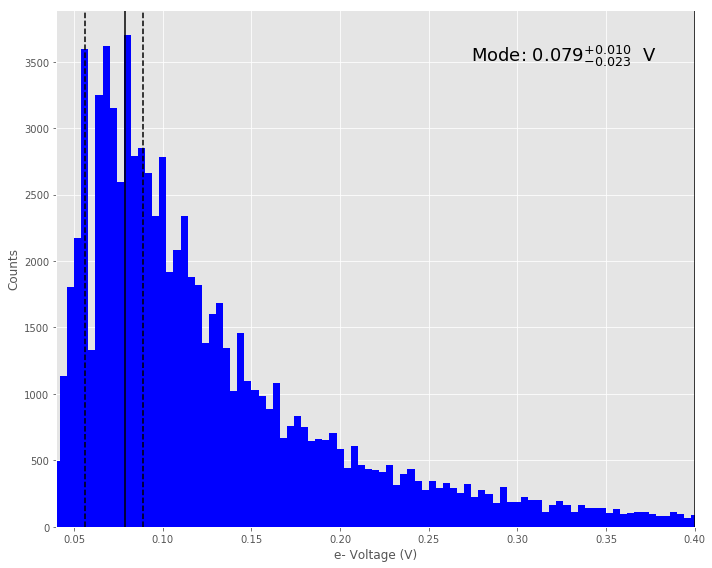

In [352]:
min_cut,max_cut,bin_mult = (0.04, .4, 1)

fig = plt.figure(figsize=(10,8))
G = gridspec.GridSpec(3,1)
ax1 = plt.subplot(G[:3, :])

n,bins,paint = plt.hist(df_calib.e.values, bins=-.002+np.arange(0,max(df_calib.e) + .1, bin_mult*.004), color='b')
middles = (bins[:-1] + bins[1:]) / 2.
ixes_to_keep = [ix for ix in range(len(middles)) if min_cut <= middles[ix] <= max_cut]
uncert = np.sqrt(n[ixes_to_keep])

popt,pcov = curve_fit(landau_f ,middles[ixes_to_keep] , n[ixes_to_keep], 
                      sigma=uncert,
                      p0 = [ 3229.03208217,    54.6999492,      4.29984796],
                     ) 
popt = [ 3229.03208217,    54.6999492,      4.29984796]

plt.axvline(min_cut, color='k')
plt.axvline(max_cut, color='k')
preds = (popt[0]*landau(popt[1]*middles, popt[2], 1.0))
chi2 = np.sqrt(np.mean(np.square((preds[ixes_to_keep] - n[ixes_to_keep]) / np.sqrt(n[ixes_to_keep]))))
print chi2
print np.sqrt(np.diagonal(pcov))
print 'params:',popt
x_eval = np.linspace(0.02,1, 500)
y_eval = popt[0]*landau(popt[1]*x_eval, popt[2], 1.0)
#plt.plot(x_eval, y_eval, 'g')
plt.xlim(min_cut, max_cut)

peak = max(y_eval)
peak_ix = np.argmax(y_eval)
plt.axvline(x_eval[peak_ix], color='k')

# lefts = [abs(y_eval[ix] - peak/2.) for ix in range(peak_ix)]
# left_bound = x_eval[np.argmin(lefts)]
left_bound = .079 - .023
plt.axvline(left_bound, color='k', linestyle='--')

# rights = [abs(y_eval[ix] - peak/2.) for ix in range(peak_ix, len(y_eval))]
# right_bound = x_eval[np.argmin(rights) + peak_ix]
right_bound = .079 + .01
plt.axvline(right_bound, color='k', linestyle='--')


plt.annotate(r'Mode: ' + "{0:.3f}".format(round(x_eval[peak_ix], 3)) + r'$^{+' + "{0:.3f}".format(round(right_bound - x_eval[peak_ix], 3)) + r'}_{-' + "{0:.3f}".format(round(x_eval[peak_ix] - left_bound, 3))+ r'}$'  + r'  V', xy=(0.65, .9), fontsize=18, xycoords = 'axes fraction')
plt.xlabel('e- Voltage (V)')
plt.ylabel('Counts')
#ax2 = plt.subplot(G[2,:], sharex=ax1)
#ax2.bar(middles[ixes_to_keep],(preds[ixes_to_keep] - n[ixes_to_keep]) / np.sqrt(n[ixes_to_keep]), middles[1]-middles[0], 0)
#plt.xlim(min_cut, max_cut)

#plt.annotate(r'$\sqrt{\chi^2 /n}$ = ' + str(round(chi2, 2)), xy=(0.85, 0.7), xycoords = 'axes fraction')


plt.tight_layout()
plt.savefig('../plots/final_calib_non.pdf')
plt.show()

In [ ]:
######################################################

In [13]:
df0 = read_data('../data/2017_09_14_Muon_Lifetime.txt')
df1 = read_data('../data/2017_09_21_Mass.txt')
df2 = read_data('../data/2017_09_21_Mass2.txt')

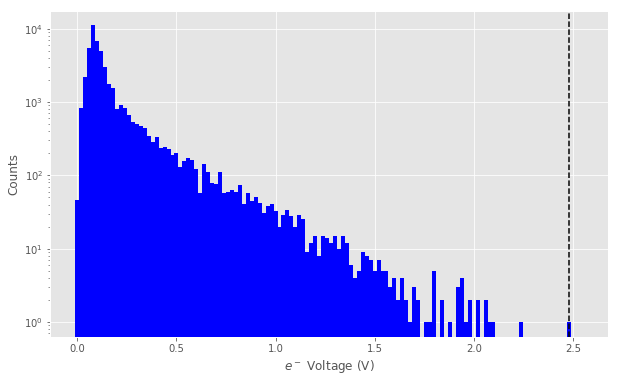

In [37]:
fig = plt.figure(figsize=(10,6))
bin_mult = 1.
n,bins,paint = plt.hist(df2.e.values, bins=-.01+np.arange(0,max(df2.e) + .1, bin_mult*.02), color='b')
middles = (bins[:-1] + bins[1:]) / 2.
plt.yscale('log')
plt.xlabel(r'$e^-$ Voltage (V)')
plt.ylabel('Counts')

plt.axvline(max(df2.e.values), color='k', linestyle='--')

plt.savefig('../plots/final_ehist.pdf')
plt.show()
# mini = 40
# for val1,val2 in itertools.product(df2.e.values, df2.e.values):
#     if 0<abs(val1 - val2) < mini:
#         mini = abs(val1 - val2)
#         print mini

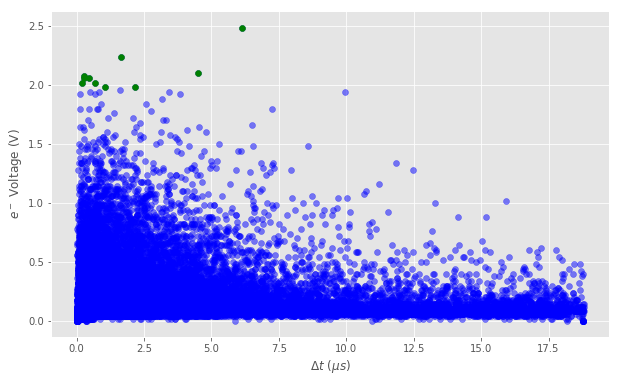

In [61]:
fig = plt.figure(figsize=(10,6))
plt.scatter(df2.life.values, df2.e.values, c='b', alpha=.5)
sorted_ixes = np.flip(np.argsort(df2.e.values), 0)
for i in range(10):
    plt.scatter(df2.life.values[sorted_ixes[i]], df2.e.values[sorted_ixes[i]], c='g')
#plt.yscale('log')
plt.xlabel(r'$\Delta t$ $(\mu s)$')
plt.ylabel(r'$e^-$ Voltage (V)')

plt.savefig('../plots/final_evst.pdf')
plt.show()

[  2.11657569e+00   4.41273668e-04   3.18369772e-02] [  7.01439862e-03   2.18421340e+01   8.71013217e-01]


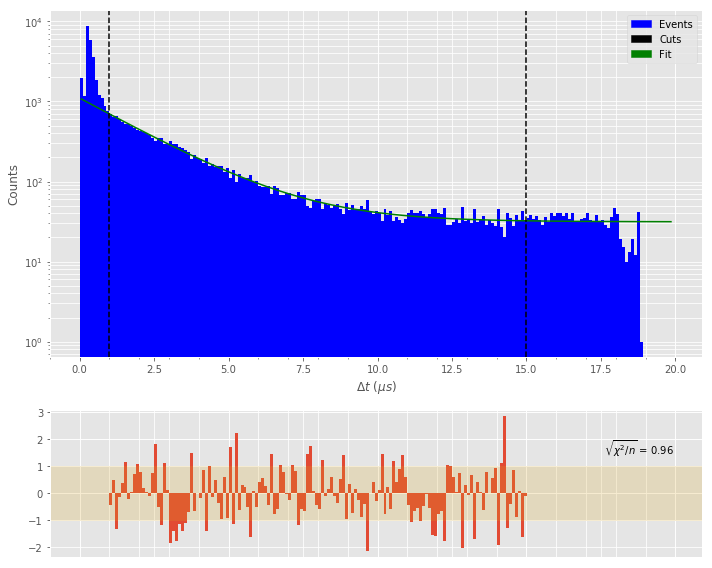

In [62]:
popt,n,middles = lifetime_fit(df2.life.values, 'junk.pdf', 'Run 2', system_err=False)

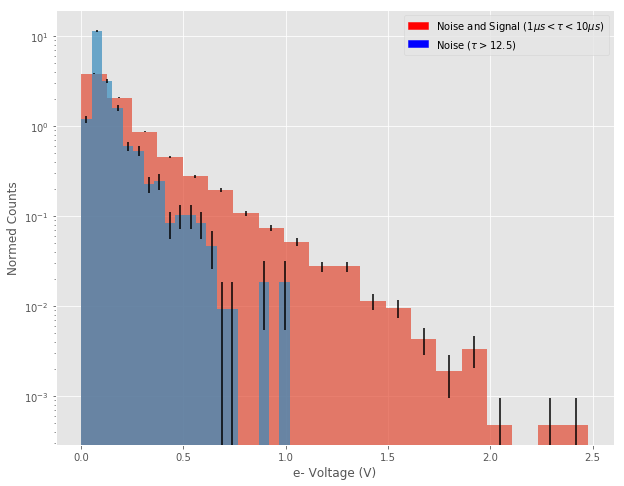

In [15]:
fig = plt.figure(figsize=(10,8))
# good events
first_df = df2[np.logical_and(df2.life < 10.0, df2.life>1.0)]
nn,bins,paints = plt.hist(first_df.e, bins=20, normed=True, alpha=.7)
fig1 = plt.figure()
n,bins,paints = plt.hist(first_df.e, bins=20, normed=False, alpha=.7)
plt.close(fig1)
middles = (bins[:-1] + bins[1:]) / 2.
rescale = nn[0] / float(n[0])
plt.errorbar(middles, nn, xerr=0, yerr=rescale*np.sqrt(n), fmt='none', color='k')


#bad events
first_df = df2[df2.life > 12.5]
nn,bins,paints = plt.hist(first_df.e, bins=20, normed=True, alpha=.7)
fig1 = plt.figure()
n,bins,paints = plt.hist(first_df.e, bins=20, normed=False, alpha=.7)
plt.close(fig1)
middles = (bins[:-1] + bins[1:]) / 2.
rescale = nn[0] / float(n[0])
plt.errorbar(middles, nn, xerr=0, yerr=rescale*np.sqrt(n), fmt='none', color='k')

plt.yscale('log')
plt.legend(handles=[mpatches.Patch(color='r', label=r'Noise and Signal $(1 \mu s<\tau<10 \mu s)$'),
                    mpatches.Patch(color='b', label=r'Noise ($\tau > 12.5$)'),
                        ])
plt.xlabel('e- Voltage (V)')
plt.ylabel('Normed Counts')
#plt.savefig('../plots/final_noisesigcompare_linear.pdf')
plt.show()

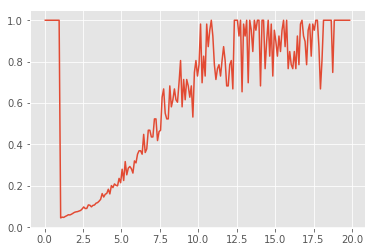

In [67]:
probs = [popt[2]/n[ix] if n[ix] > 20 and popt[2]/n[ix] < 1. and mi>1 else 1.0 for ix,mi in enumerate(middles)]
plt.plot(middles, probs)
plt.show()

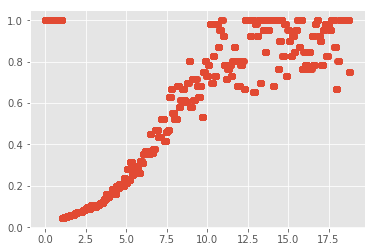

In [69]:
preds = np.array([probs[max(0, np.searchsorted(middles, val) - 1)] for ix,val in enumerate(df2.life.values)])
plt.plot(df2.life.values, preds, 'o')

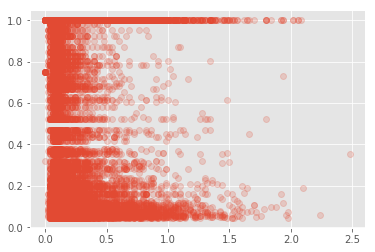

In [70]:
plt.plot(df2.e.values, preds, 'o', alpha=.2)
plt.show()

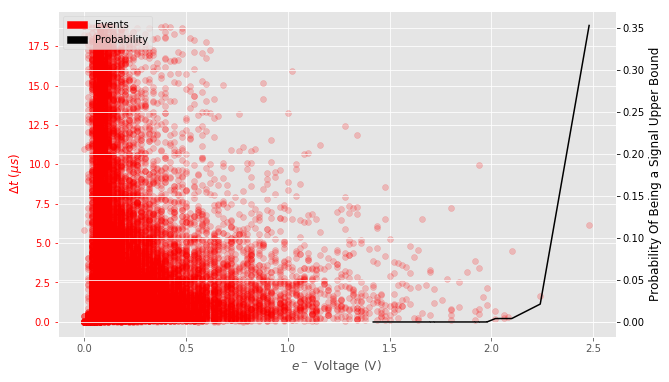

In [106]:
x_list = []
y_list = []
ixes_sorted = np.flip(np.argsort(df2.e.values), 0)

for i in range(100):
    x_list.append(df2.e.values[ixes_sorted[i]])
    y_list.append(np.product(preds[ixes_sorted[:(i+1)]]))
fig = plt.figure(figsize=(10,6))

plt.scatter(df2.e.values, df2.life.values, color='r',alpha=.2)
ax1 = plt.gca()
plt.xlabel(r'$e^-$ Voltage (V)')
plt.ylabel(r'$\Delta t$ $(\mu s)$', color='r')
ax1.tick_params('y', colors='r')
ax2 = ax1.twinx()
plt.plot(x_list, y_list, c='k')
plt.ylabel(r'Probability Of Being a Signal Upper Bound', color='k')
ax2.tick_params('y', colors='k')

plt.legend(handles=[mpatches.Patch(color='r', label=r'Events'),
                    mpatches.Patch(color='k', label=r'Probability'),
                        ])

plt.savefig('../plots/final_probdrop.pdf')
plt.show()

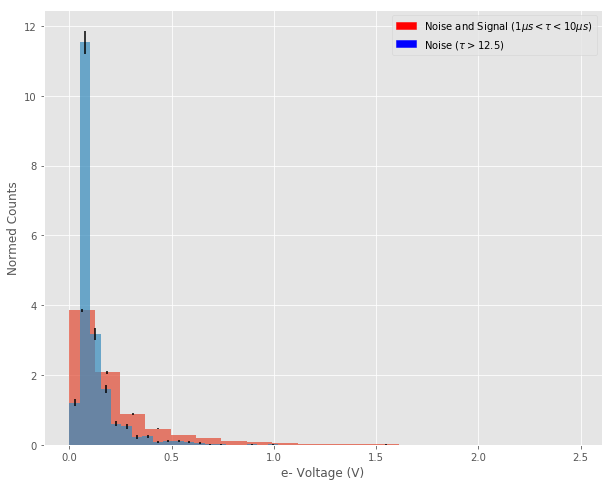

In [330]:
len(df2[np.logical_and(df2.life < 10.0, df2.life>1.0)].e)

16817

In [332]:
len(df2[df2.life > 12.5].e)

2080

In [335]:
len(middles)*31

6169

In [107]:
len(df0) + len(df1) + len(df2)

112578

In [112]:
(max(df2.clock) - min(df2.clock))/(60*60*24)

6.8843707986111111